In [23]:
import pandas as pd 

import numpy as np 
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.api import types

from linearmodels import PanelOLS
import causallib as cl
from causallib.estimation import IPW

from sklearn.linear_model import LogisticRegression, LinearRegression

from econml.dml import DML
from econml.dr import LinearDRLearner # Example of a direct DR learner

In [24]:
data = pd.read_csv("src/did_training_productivity.csv", index_col = 0)
data["interaction"] = data["post"]*data["treat_group"]

### Inverse probability weighting

In [25]:
data.columns

Index(['period', 'female', 'mothers_educ', 'technical', 'immigrant',
       'base_productivity', 'treat_group', 'tenure', 'prev_performance',
       'team_size', 'manager_exp', 'post', 'treated', 'treat_hours',
       'productivity', 'log_productivity', 'interaction'],
      dtype='object')

In [26]:
covariates = data[['female', 'mothers_educ', 'technical', 'immigrant',
                   'base_productivity', 'tenure', 'prev_performance',
                   'team_size', 'manager_exp']].copy()

In [27]:
ordinal_map = {'<HS': 0, 'HS': 1, 'College': 2, 'Graduate': 3}
covariates["mothers_educ"] = covariates["mothers_educ"].map(ordinal_map)

In [28]:
learner = LogisticRegression(penalty="l1", C=0.01, max_iter=500, solver='liblinear')
ipw = IPW(learner)
ipw.fit(covariates, data["treat_group"])

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.6/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(C=0.01, max_iter=500, penalty='l1', solver='liblinear'))

In [29]:
weights = ipw.compute_weights(covariates, data["treat_group"])
data['ipw_weight'] = weights

In [30]:
reg_data = data.reset_index().copy()
reg_data = reg_data.set_index(["worker_id", "period"])

y = reg_data["productivity"].copy()
X = reg_data["interaction"].copy()

In [31]:
weighted_model = PanelOLS(y,X, entity_effects=True, time_effects=True, weights=data['ipw_weight']).fit(cov_type= "clustered", cluster_entity = True)

In [32]:
weighted_model

Dep. Variable:,productivity,R-squared:,0.2191
Estimator:,PanelOLS,R-squared (Between):,0.0802
No. Observations:,48000,R-squared (Within):,0.4271
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.0856
Time:,17:54:05,Log-likelihood,-1.812e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.29e+04
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,45976)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,1.018e+04


### Regression adjustment

In [33]:
covariates_name = ['female', 'mothers_educ', 'technical', 'immigrant',
                   'base_productivity', 'tenure', 'prev_performance',
                   'team_size', 'manager_exp']

ordinal_map = {'<HS': 0, 'HS': 1, 'College': 2, 'Graduate': 3}

covariates_regdata = reg_data[covariates_name].copy()
covariates_regdata["mothers_educ"] = covariates_regdata["mothers_educ"].map(ordinal_map)

X_adjusted = pd.concat([X, covariates_regdata], axis = 1)

In [34]:
# need to drop entity fixed effects to prevent multicollinearity
regression_adjustment = PanelOLS(y,X_adjusted, entity_effects=False, time_effects=True, drop_absorbed= True).fit(cov_type= "clustered", cluster_entity = True)

In [35]:
regression_adjustment

Dep. Variable:,productivity,R-squared:,0.7677
Estimator:,PanelOLS,R-squared (Between):,0.9995
No. Observations:,48000,R-squared (Within):,0.5910
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.9940
Time:,17:54:09,Log-likelihood,-1.795e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.585e+04
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(10,47966)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,1.564e+04


### Doubly Robust Estimator

In [38]:
Y = data['productivity'].values  # Outcome
T = data['treat_group'].values    # Treatment (binary)
X = covariates_regdata.values  # Features/Covariates
W = None

In [39]:
est = LinearDRLearner()
est.fit(y, T, X=X, W=W)
point = est.effect(X, T1=1)
lb, ub = est.effect_interval(X, T1=1, alpha=0.05)
# Get CATE for all treatments
point = est.const_marginal_effect(X)
lb, ub = est.const_marginal_effect_interval(X, alpha=0.05)

c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

In [43]:
overall_ate = point.mean()
print("\nAverage Marginal Effect(s):")
print(point)
print(f"\nOverall Average Treatment Effect: {overall_ate}")


Average Marginal Effect(s):
[[  1.0362054 ]
 [-10.45214394]
 [  1.22547425]
 ...
 [ 23.99668178]
 [ 23.69631963]
 [ 23.91367685]]

Overall Average Treatment Effect: 13.588682120819927


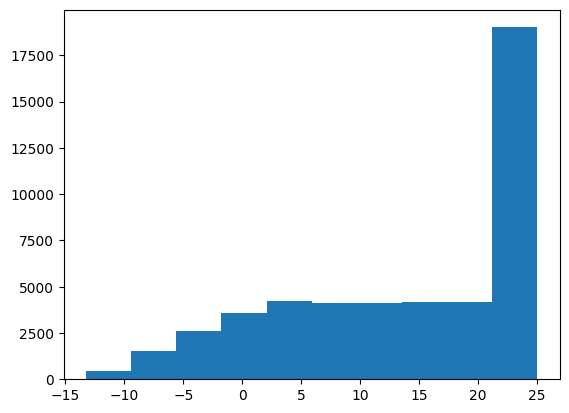

In [46]:
plt.hist(point);